## Introduction

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Dec 15 21:42:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
# Print the current working directory
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


## Install YOLO11 via Ultralytics

In [3]:
%pip install -q --upgrade ultralytics supervision roboflow
import ultralytics

# Check the installation
ultralytics.checks()

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6013.4/8062.4 GB disk)


## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from kaggle_secrets import UserSecretsClient
from roboflow import Roboflow

# Get the Roboflow API key
roboflow_secret_value = UserSecretsClient().get_secret("ROBOFLOW_SECRET_KEY")
rf = Roboflow(api_key=roboflow_secret_value)

# Download the dataset
project = rf.workspace("ben10-zvdpq").project("eye-retinal-disease")
version = project.version(1)
dataset = version.download("yolov11")              

/kaggle/working/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Eye-Retinal-Disease--1 in yolov11:: 100%|██████████| 8428/8428 [00:00<00:00, 10542.20it/s]


### Custom Training

In [5]:
%cd {HOME}

# Train the model using the downloaded dataset and the YOLO11 medium model with other parameters
!yolo task=detect mode=train model=yolo11m.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 plots=True

/kaggle/working
100%|███████████████████████████████████████| 38.8M/38.8M [00:00<00:00, 181MB/s]
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/kaggle/working/datasets/Eye-Retinal-Disease--1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

NOTE: The results of the completed training are saved in {HOME}/runs/detect/train/. Let's examine them.



In [6]:
# Check the training results
!ls {HOME}/runs/detect/train/

F1_curve.png					  train_batch1.jpg
PR_curve.png					  train_batch2.jpg
P_curve.png					  train_batch7400.jpg
R_curve.png					  train_batch7401.jpg
args.yaml					  train_batch7402.jpg
confusion_matrix.png				  val_batch0_labels.jpg
confusion_matrix_normalized.png			  val_batch0_pred.jpg
events.out.tfevents.1734299062.6e18c5339e19.79.0  val_batch1_labels.jpg
labels.jpg					  val_batch1_pred.jpg
labels_correlogram.jpg				  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


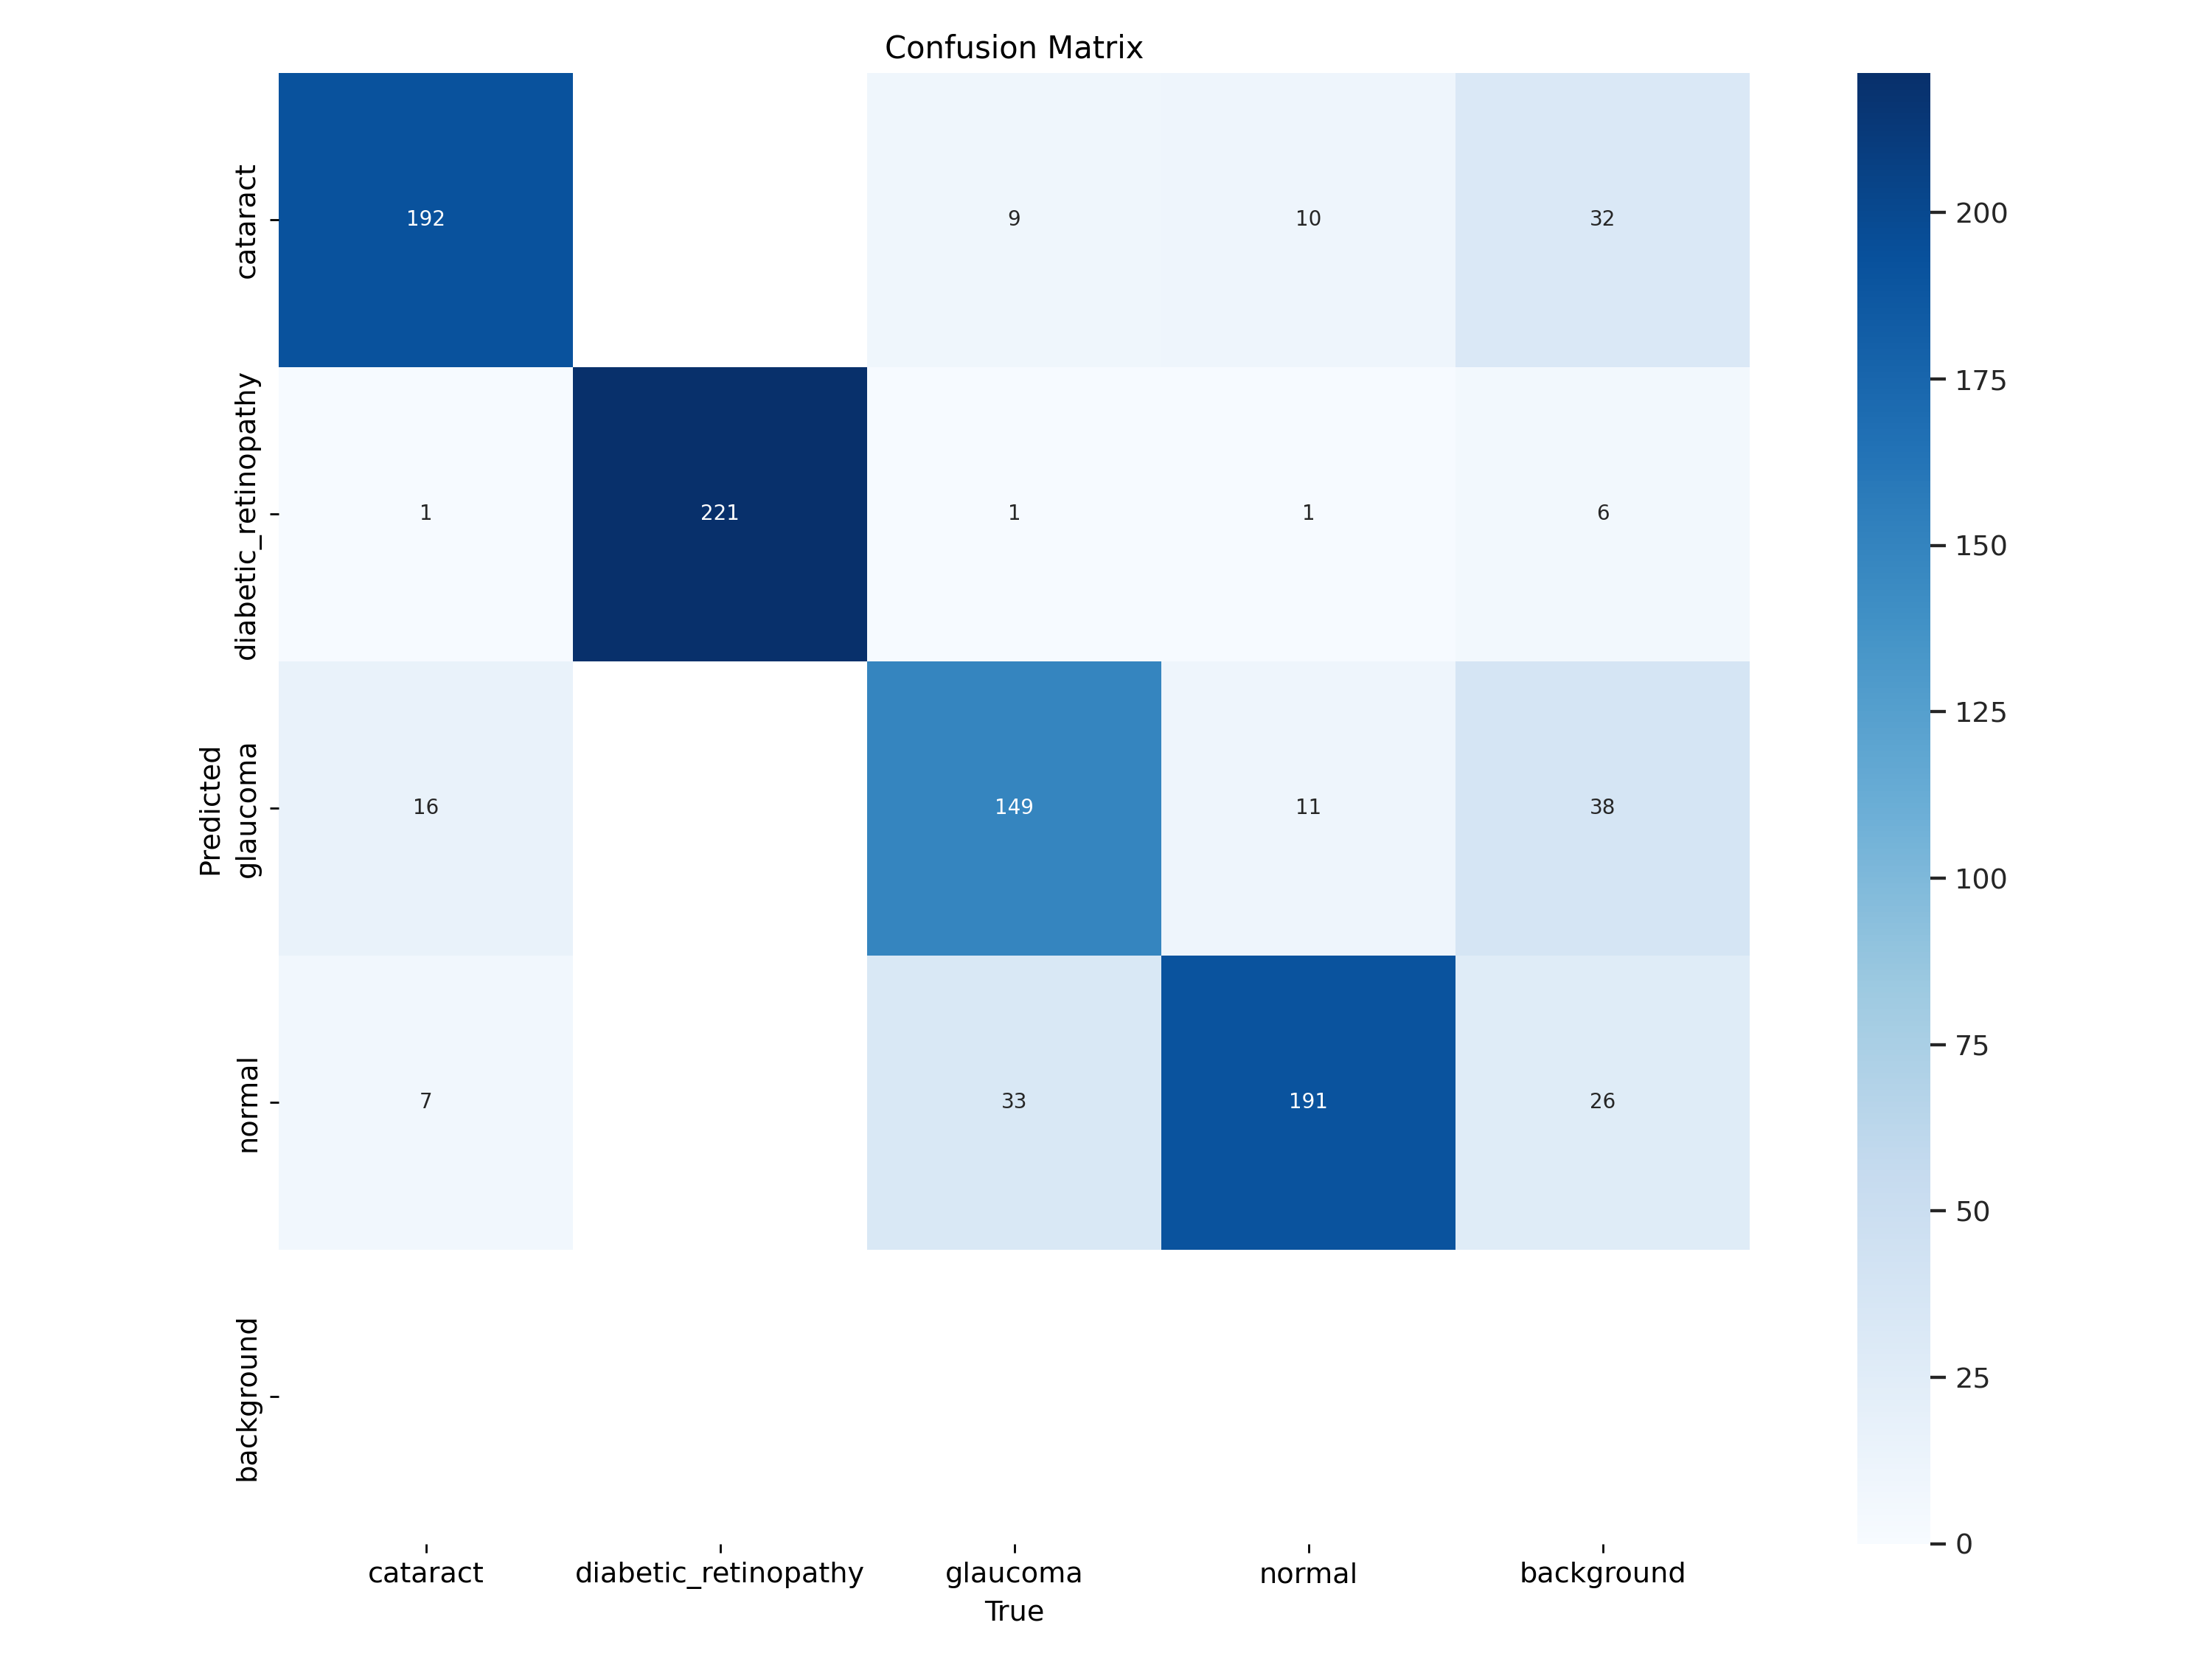

In [7]:
from IPython.display import Image as IPyImage

# Display the confusion matrix plot
IPyImage(filename=f"{HOME}/runs/detect/train/confusion_matrix.png", width=600)

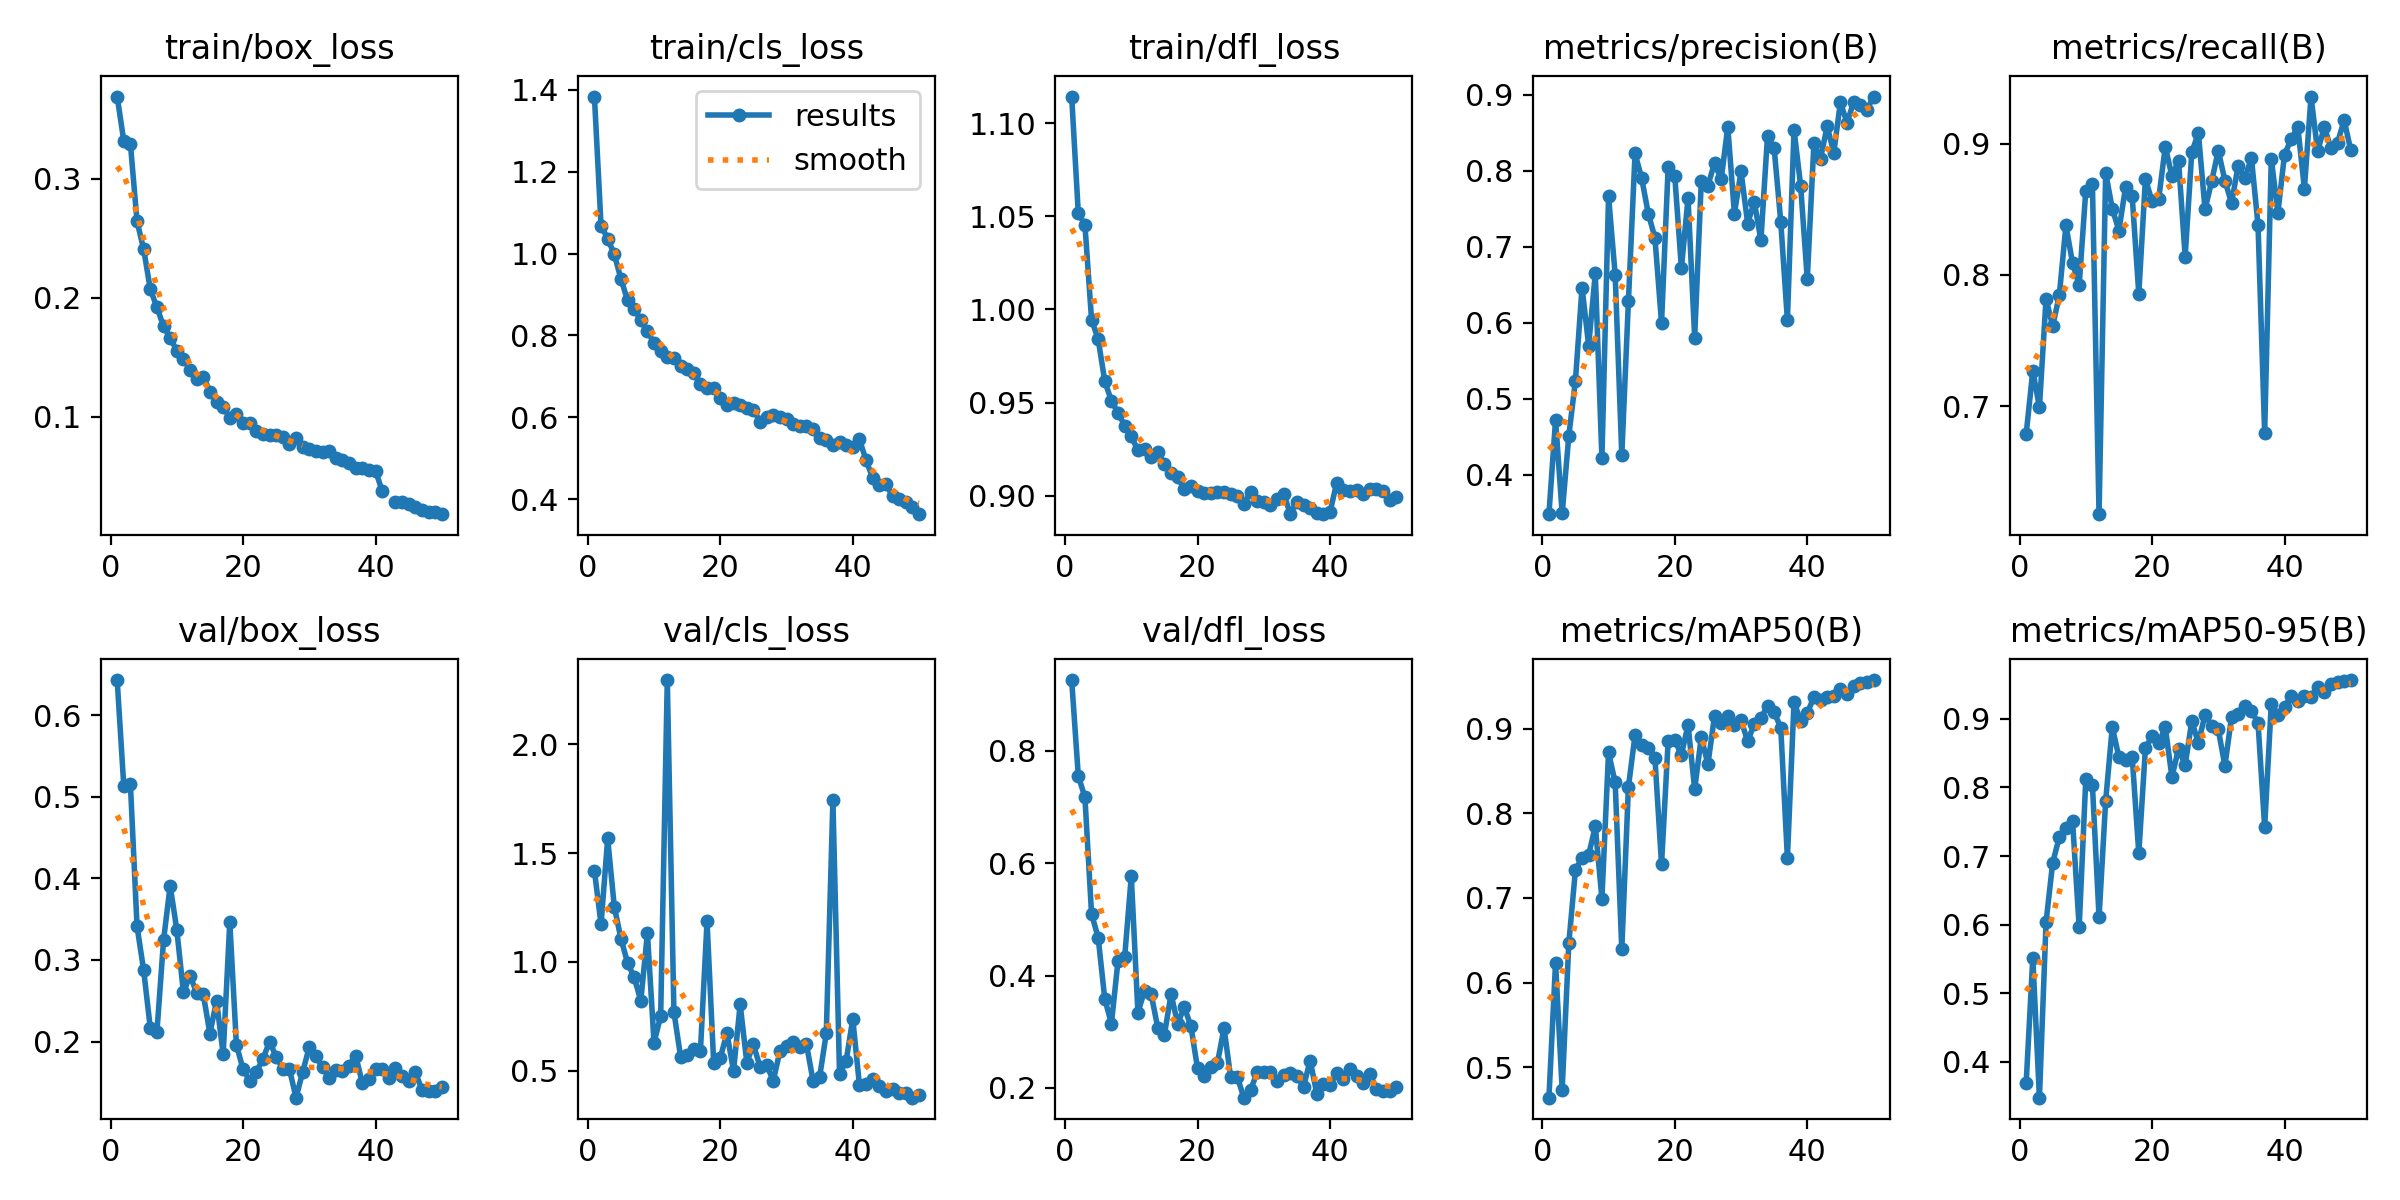

In [8]:
# Display the training results plot
IPyImage(filename=f"{HOME}/runs/detect/train/results.png", width=600)

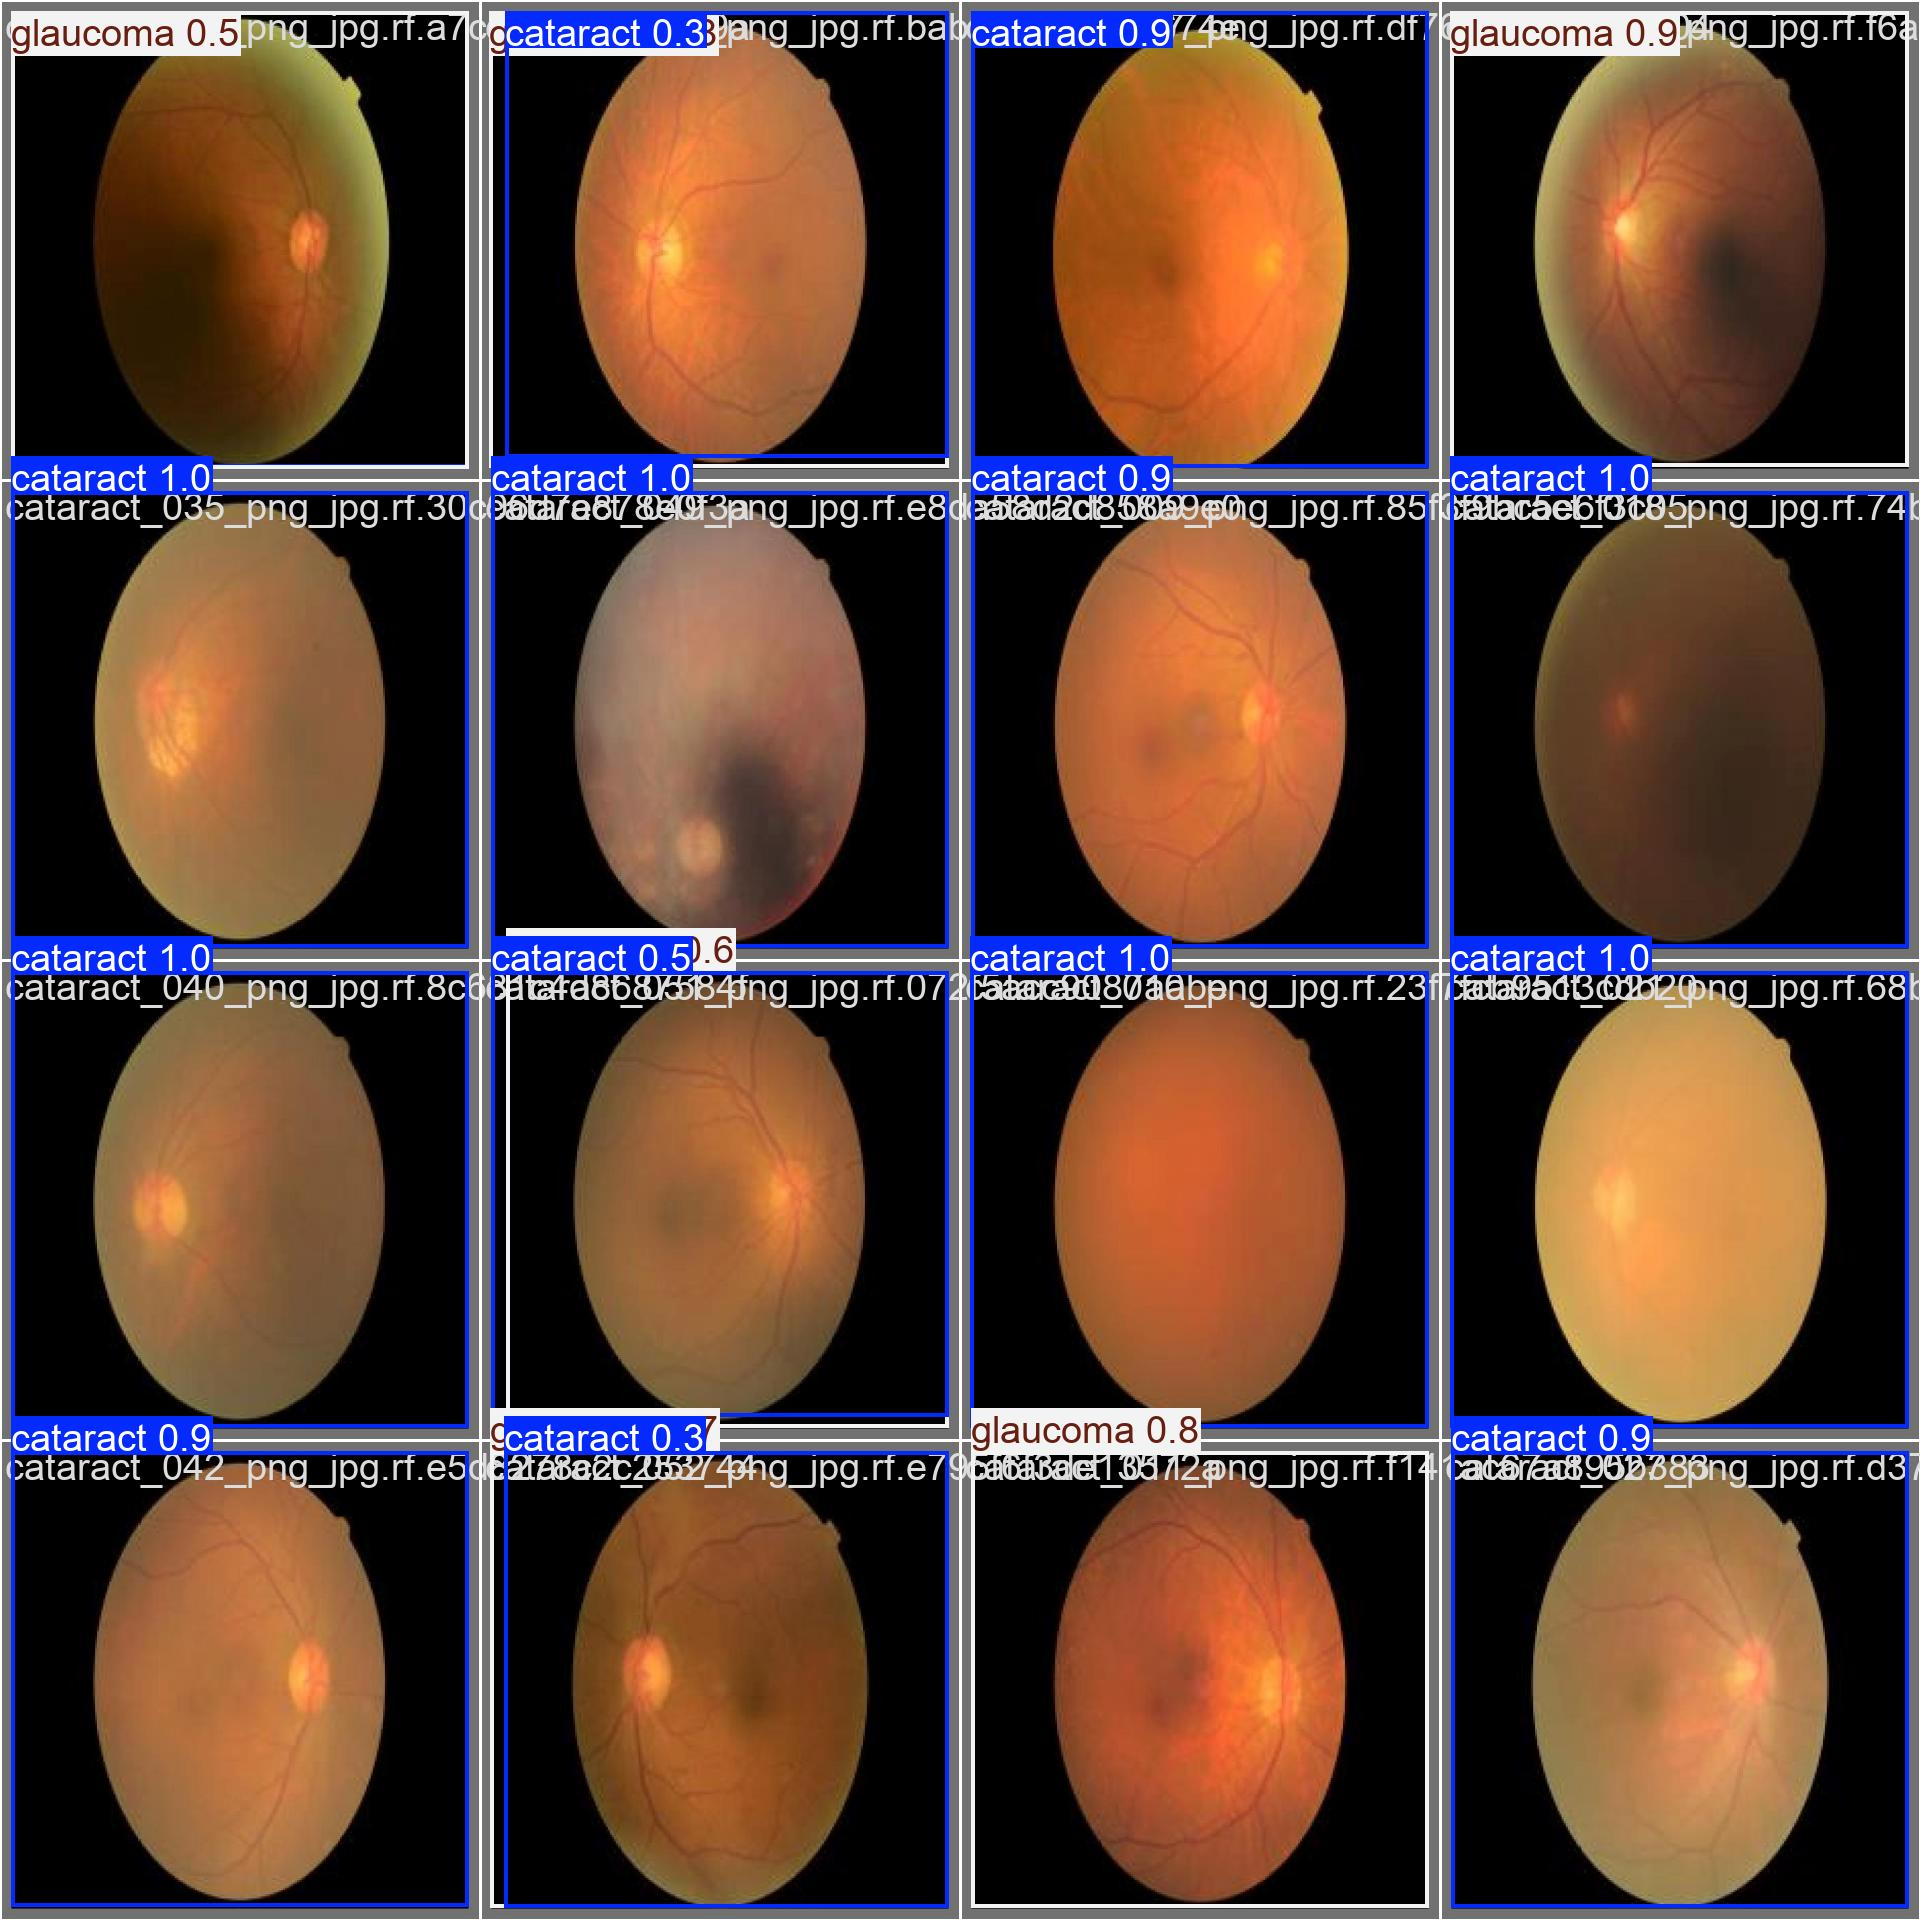

In [9]:
# Display the validation batched prediction plot
IPyImage(filename=f"{HOME}/runs/detect/train/val_batch0_pred.jpg", width=600)

### Validate fine-tuned model

In [10]:
# Evaluate the model using the validation dataset and the best weights
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Scanning /kaggle/working/datasets/Eye-Retinal-Disease--1/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        842        842      0.897      0.895      0.957      0.956
              cataract        216        216      0.912      0.907      0.977      0.976
  diabetic_retinopathy        221        221      0.979          1      0.995      0.995
              glaucoma        192        192      0.855      0.776      0.917      0.911
                normal        213        213      0.841      0.897      0.941      0.941
Speed: 0.6ms preprocess, 25.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


### Inference with custom model

In [11]:
# Predict the test dataset using the best weights
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs

image 1/417 /kaggle/working/datasets/Eye-Retinal-Disease--1/test/images/10003_left_jpeg_jpg.rf.935892a3423d38e1fb611453cb8c973f.jpg: 640x640 1 diabetic_retinopathy, 36.8ms
image 2/417 /kaggle/working/datasets/Eye-Retinal-Disease--1/test/images/1000_right_jpeg_jpg.rf.48af6756669f3378e65baa50a68fcad4.jpg: 640x640 1 normal, 36.9ms
image 3/417 /kaggle/working/datasets/Eye-Retinal-Disease--1/test/images/1002_left_jpeg_jpg.rf.572a76f68a1008563a809fc0d76c4452.jpg: 640x640 1 diabetic_retinopathy, 36.8ms
image 4/417 /kaggle/working/datasets/Eye-Retinal-Disease--1/test/images/10030_right_jpeg_jpg.rf.cc07b7ecc34a520cf5680219a1a56ff0.jpg: 640x640 1 diabetic_retinopathy, 36.8ms
image 5/417 /kaggle/working/datasets/Eye-Retinal-Disease--1/test/images/10031_left_jpeg_jpg.rf.6ee696ca3f96aeef2d0149949c9415a0.jpg: 640x640 1 diabetic_retinopathy,

NOTE: Let's take a look at few results.



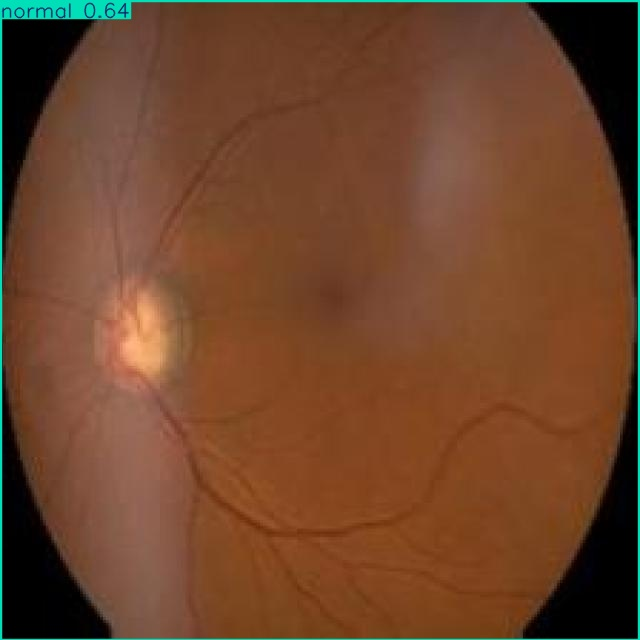

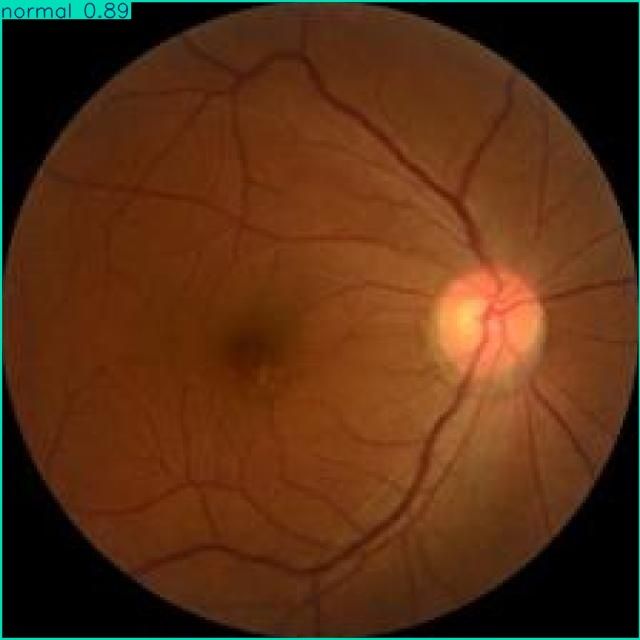

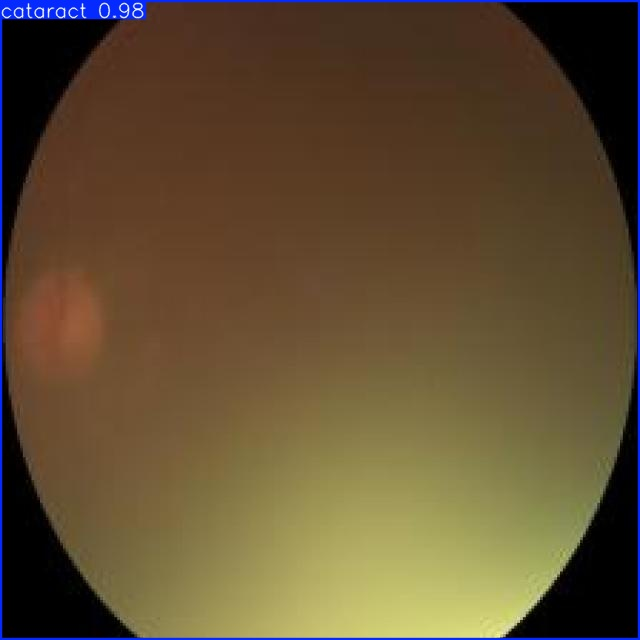

In [12]:
import glob
from IPython.display import Image as IPyImage, display

# Get the latest prediction folder
latest_folder = max(glob.glob(f"{HOME}/runs/detect/predict*/"), key=os.path.getmtime)

# Display the first 3 images from the test dataset
for img in glob.glob(f"{latest_folder}/*.jpg")[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Conclusion